In [1]:
import gymnasium as gym
from twsbr_env.envs import TwsbrEnv  # Import environment
import time
from stable_baselines3.common.env_checker import check_env

env = gym.make("TwsbrEnv-v0",
                render_mode="human",
                )
check_env(env)
env.close()

In [2]:
import gymnasium as gym
from twsbr_env.envs import TwsbrEnv  # Import environment
import time
from stable_baselines3.common.env_checker import check_env

env = gym.make("TwsbrEnv-v0",
                render_mode="human",
                )

 0.09543141092712581 
 0.9527888877719056 
 -0.0888888888888889 
 0.375 
 0.17089605369986682 
 0.3979810527726716 
 -0.09999999999999998 
 0.3671596200028171 
 0.2667220384068826 
 0.7767359116498161 
 -0.09999999999999998 
 0.375 
 0.39237566598031604 
 1.0 
 1.0 
 0.375 
 OK  Episode selesai!


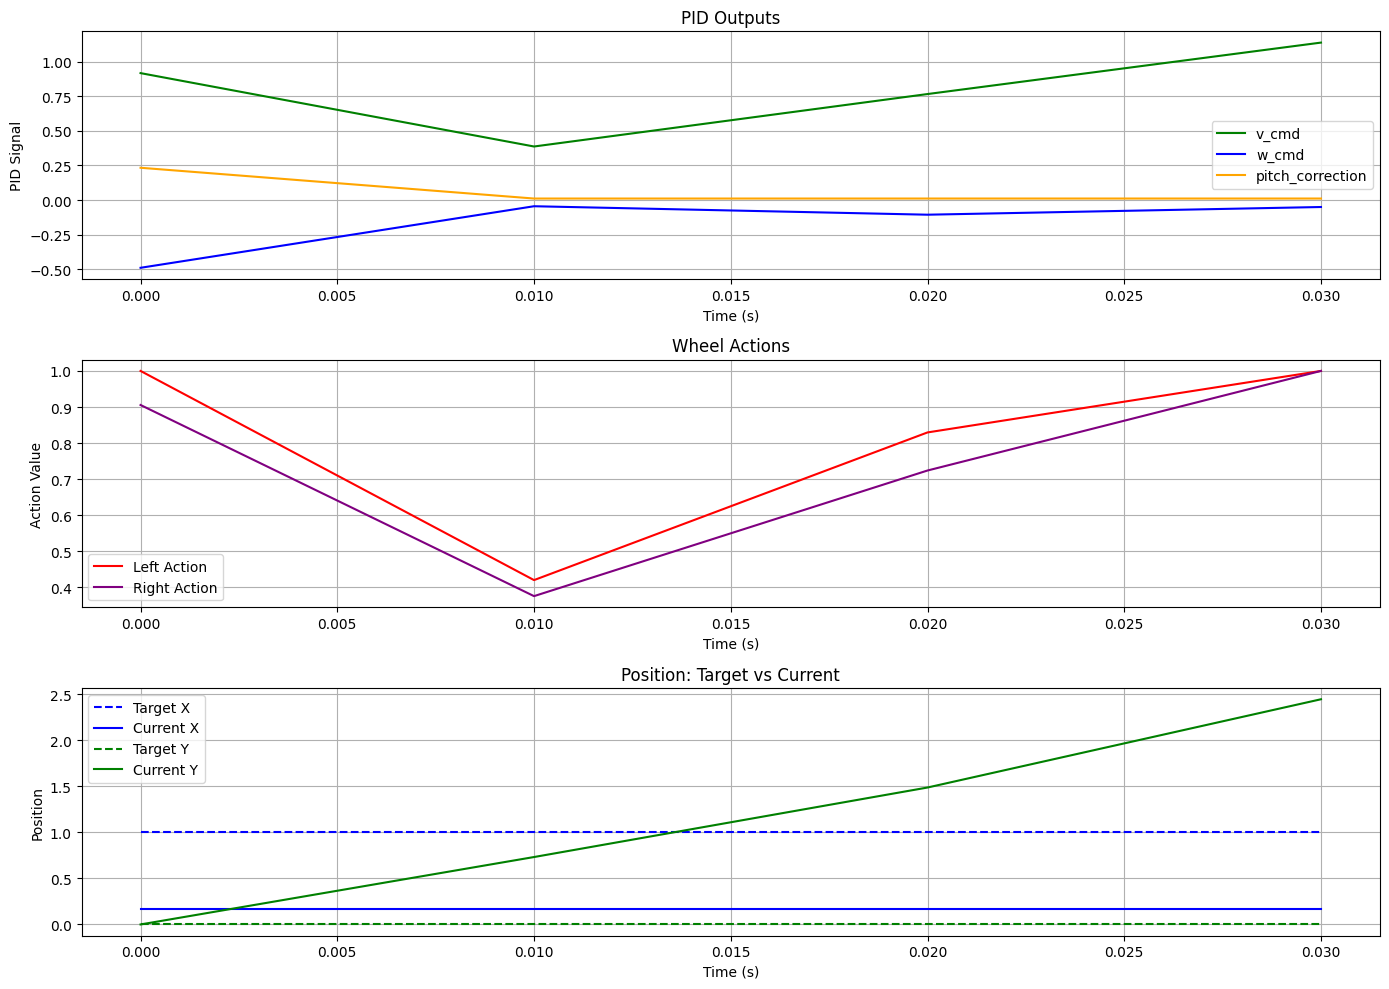

In [1]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from twsbr_env.envs import TwsbrEnv 

# PID Controller sederhana
class PID:
    def __init__(self, kp, ki, kd, dt):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integral = 0.0
        self.prev_error = 0.0

    def update(self, error):
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        self.prev_error = error
        return self.kp * error + self.ki * self.integral + self.kd * derivative

def plot_results(time_list, pid_data, action_data, pos_data, target_data):
    # Grafik output PID
    plt.figure(figsize=(14, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(time_list, pid_data['v_cmd'], label="v_cmd", color='green')
    plt.plot(time_list, pid_data['w_cmd'], label="w_cmd", color='blue')
    plt.plot(time_list, pid_data['pitch_correction'], label="pitch_correction", color='orange')
    plt.title("PID Outputs")
    plt.xlabel("Time (s)")
    plt.ylabel("PID Signal")
    plt.legend()
    plt.grid()
    
    # Grafik aksi roda
    plt.subplot(3, 1, 2)
    plt.plot(time_list, action_data['left_action'], label="Left Action", color='red')
    plt.plot(time_list, action_data['right_action'], label="Right Action", color='purple')
    plt.title("Wheel Actions")
    plt.xlabel("Time (s)")
    plt.ylabel("Action Value")
    plt.legend()
    plt.grid()
    
    # Grafik posisi: Target vs Current untuk x dan y
    plt.subplot(3, 1, 3)
    plt.plot(time_list, target_data['x'], label="Target X", linestyle='--', color='blue')
    plt.plot(time_list, pos_data['current_x'], label="Current X", color='blue')
    plt.plot(time_list, target_data['y'], label="Target Y", linestyle='--', color='green')
    plt.plot(time_list, pos_data['current_y'], label="Current Y", color='green')
    plt.title("Position: Target vs Current")
    plt.xlabel("Time (s)")
    plt.ylabel("Position")
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

def main():
    # Daftar waypoint (target) [x, y, yaw]
    # Robot mulai di (0,0) dan target yang ingin dicapai adalah:
    # (1,0) -> (1,1) -> (2,1) -> (2,2) -> (0,2) -> (0,0)
    waypoints = [
        np.array([1.0, 0.0, 0.0]),
        np.array([1.0, 1.0, 0.0]),
        np.array([2.0, 1.0, 0.0]),
        np.array([2.0, 2.0, 0.0]),
        np.array([0.0, 2.0, 0.0]),
        np.array([0.0, 0.0, 0.0])
    ]
    current_wp_index = 0
    current_target = waypoints[current_wp_index].copy()
    
    # Buat environment dengan target awal sesuai waypoint pertama
    env = TwsbrEnv(render_mode="human",)
    obs, info = env.reset()

    # Buat PID controller untuk:
    # - Linear (jarak terhadap target)
    # - Yaw (perbedaan orientasi; jika tidak diperlukan bisa diabaikan atau dihitung dari current ke target)
    # - Pitch (untuk menjaga agar pitch mendekati 0, agar robot tetap seimbang)
    dt = 1 / env.render_fps
    pid_linear = PID(kp=0.1, ki=0.0, kd=0.01, dt=dt)
    pid_yaw = PID(kp=0.5, ki=0.0, kd=0.05, dt=dt)
    pid_pitch = PID(kp=0.5, ki=0.1, kd=0.1, dt=dt)  # menjaga agar pitch mendekati 0

    max_steps = 1000
    step = 0

    # Data storage untuk plotting
    time_list = []
    pid_data = {
        'v_cmd': [],
        'w_cmd': [],
        'pitch_correction': []
    }
    action_data = {
        'left_action': [],
        'right_action': []
    }
    pos_data = {
        'current_x': [],
        'current_y': []
    }
    target_data = {
        'x': [],
        'y': []
    }

    # Threshold untuk menentukan jika target sudah tercapai (dalam satuan fisik, misalnya 0.5)
    threshold = 0.5
    # Skala error untuk mengubah nilai normalized menjadi error fisik (sesuaikan dengan environment-mu)
    error_scale = 10

    while step < max_steps:
        current_time = step * dt
        time_list.append(current_time)
        
        # Jika environment menghitung error berdasarkan target yang diberikan, maka:
        # pos_error_x, pos_error_y adalah error normalized relatif terhadap current_target
        pos_error_x = obs[1]
        pos_error_y = obs[2]

        # Hitung posisi current berdasarkan target dan error (asumsi error fisik = normalized_value * error_scale)
        current_x = current_target[0] - pos_error_x * error_scale
        current_y = current_target[1] - pos_error_y * error_scale

        pos_data['current_x'].append(current_x)
        pos_data['current_y'].append(current_y)
        target_data['x'].append(current_target[0])
        target_data['y'].append(current_target[1])

        # Hitung jarak error (dalam satuan fisik)
        distance_error = math.sqrt((pos_error_x * error_scale)**2 + (pos_error_y * error_scale)**2)

        # (Opsional) Jika kamu ingin menghitung yaw berdasarkan current position ke target:
        # Misalnya, jika environment tidak menghitung yaw error secara otomatis:
        # current_yaw = ...  (dapat diperoleh dari observasi atau state robot)
        # desired_yaw = math.atan2(current_target[1] - current_y, current_target[0] - current_x)
        # yaw_error = desired_yaw - current_yaw
        # Namun, jika environment sudah mengembalikan yaw error di obs[3], kita bisa langsung menggunakannya.
        yaw_error = obs[3]
        pitch = obs[0]  # Pitch normalized (ideal = 0)

        # Update PID untuk masing-masing error
        v_cmd = pid_linear.update(distance_error)
        w_cmd = pid_yaw.update(yaw_error)
        pitch_correction = pid_pitch.update(pitch)

        pid_data['v_cmd'].append(v_cmd)
        pid_data['w_cmd'].append(w_cmd)
        pid_data['pitch_correction'].append(pitch_correction)

        # Kombinasikan sinyal linear dengan koreksi pitch
        v_cmd_total = v_cmd + pitch_correction

        # Konversi sinyal kontrol ke perintah motor dengan sistem differential drive
        wheel_base_factor = 0.5
        left_cmd = v_cmd_total - wheel_base_factor * w_cmd
        right_cmd = v_cmd_total + wheel_base_factor * w_cmd

        left_action = np.clip(left_cmd, -1, 1)
        right_action = np.clip(right_cmd, -1, 1)
        action = np.array([left_action, right_action])

        action_data['left_action'].append(left_action)
        action_data['right_action'].append(right_action)

        # Lakukan step pada environment
        obs, reward, terminated, truncated, info = env.step(action)
        env.render()

        # Jika jarak error kurang dari threshold, update ke target berikutnya
        if distance_error < threshold:
            current_wp_index += 1
            if current_wp_index < len(waypoints):
                current_target = waypoints[current_wp_index].copy()
                # Jika environment mendukung update target, panggil method yang sesuai.
                # Misal: env.set_target_position(current_target)
                print(f"Target baru: {current_target}")
            else:
                print("Semua waypoint telah tercapai!")
                break
        
        time.sleep(dt)
        if terminated or truncated:
            print("Episode selesai!")
            break
        
        step += 1

    env.close()
    plot_results(time_list, pid_data, action_data, pos_data, target_data)

if __name__ == "__main__":
    main()


In [ ]:
import numpy as np
import time
from twsbr_env.envs import TwsbrEnv  # Pastikan modul environment tersedia

class PIDController:
    def __init__(self, Kp, Ki, Kd, max_output, min_output):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.max_output = max_output
        self.min_output = min_output
        self.integral = 0.0
        self.prev_error = 0.0
        self.prev_time = time.time()

    def compute(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt if dt > 0 else 0.0
        
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        
        # Clamping output dan anti-windup
        if output > self.max_output:
            output = self.max_output
            self.integral -= error * dt  # Anti-windup
        elif output < self.min_output:
            output = self.min_output
            self.integral -= error * dt  # Anti-windup
        
        self.prev_error = error
        return output

def main():
    # Inisialisasi environment
    env = TwsbrEnv(render_mode="human", action_type="continuous")
    
    # Parameter PID untuk balance (pitch)
    Kp_pitch = 75.0
    Ki_pitch = 5.0
    Kd_pitch = 10.0
    max_pitch_output = 255.0  # Maksimal 255 rad/s
    
    # Parameter PID untuk steering (yaw)
    Kp_yaw = 2.5
    Ki_yaw = 0.5
    Kd_yaw = 1.0
    max_yaw_output = 100.0
    
    # Inisialisasi controller
    pid_pitch = PIDController(Kp_pitch, Ki_pitch, Kd_pitch, max_pitch_output, -max_pitch_output)
    pid_yaw = PIDController(Kp_yaw, Ki_yaw, Kd_yaw, max_yaw_output, -max_yaw_output)
    
    obs, _ = env.reset()
    last_time = time.time()
    
    try:
        while True:
            # Hitung waktu antara langkah
            current_time = time.time()
            dt = current_time - last_time
            last_time = current_time
            
            # Denormalisasi observasi
            current_target_pitch = obs[0] * np.pi
            current_pitch = obs[2] * np.pi
            current_yaw_error = obs[3] * 45.0  # Error posisi garis
            
            # Hitung error
            pitch_error = current_target_pitch - current_pitch
            
            # Hitung output PID
            balance_output = -pid_pitch.compute(pitch_error, dt)
            steering_output = -pid_yaw.compute(current_yaw_error, dt)
            
            # Gabungkan output untuk motor
            left_motor = (balance_output + steering_output) / 255.0
            right_motor = (balance_output - steering_output) / 255.0
            
            # Aksi harus dalam range [-1, 1]
            action = np.clip([left_motor, right_motor], -1.0, 1.0)
            
            # Langkah simulasi
            obs, _, terminated, truncated, _ = env.step(action)
            
            # Reset jika episode selesai
            if terminated or truncated:
                obs, _ = env.reset()
                pid_pitch.integral = 0.0
                pid_yaw.integral = 0.0
                last_time = time.time()
                
    except KeyboardInterrupt:
        print("Program dihentikan oleh pengguna")
    finally:
        env.close()

if __name__ == "__main__":
    main()

 0.020689832227671845 
 -0.020533273734298363 
 -0.0888888888888889 
 -0.00981748611854183 
 0.022335784412774173 
 -0.008651613721660567 
 -0.06666666666666665 
 -0.004136563930724146 
 0.022043487010476426 
 -0.026851489497166092 
 0.022222222222222143 
 -0.012838368415832524 
 0.020842859459593965 
 -0.019392125746783118 
 0.1333333333333333 
 -0.009271860122680664 
 0.0197423779607242 
 -0.010693299536611467 
 0.22222222222222232 
 -0.005112733840942352 
 0.021626836897893353 
 -0.009922521254595584 
 0.3111111111111111 
 -0.004744290601069623 
 0.023035932966450456 
 -0.03381652832031251 
 0.30000000000000004 
 -0.016168440170460152 
 0.02309955013599485 
 -0.03169839896407778 
 0.2333333333333334 
 -0.030311602218644595 
 0.025224828436476332 
 -0.021835177552466334 
 0.1777777777777778 
 -0.0104399724051224 
 0.026515554936463404 
 -0.038128991220511665 
 0.07777777777777772 
 -0.018230435774557185 
 0.026168419223649986 
 -0.029796585382199814 
 0.06666666666666665 
 -0.0142464

error: Not connected to physics server.